In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score


#**Functions**

In [ ]:
# Devuelve el código que permite inicializarlos
def _get_random_features_initializer(initializer, shape,seed):
    def _get_cauchy_samples(loc, scale, shape):
        np.random.seed(seed)
        probs = np.random.uniform(low=0., high=1., size=shape)
        return loc + scale * np.tan(np.pi * (probs - 0.5))

    if isinstance(initializer,str):
        if initializer == "gaussian":
            return tf.keras.initializers.RandomNormal(stddev=1.0,seed=seed)
        elif initializer == "laplacian":
            return tf.keras.initializers.Constant(
                _get_cauchy_samples(loc=0.0, scale=1.0, shape=shape))
        else:
            raise ValueError(f'Unsupported kernel initializer {initializer}')

In [ ]:
class Conv1dRFF(tf.keras.layers.Layer):

    # Contructor
    def __init__(self, output_dim, kernel_size=3, scale=None, padding='VALID', data_format='NWC', normalization=True, function=True,
                 trainable_scale=False, trainable_W=False,
                 seed=None, kernel='gaussian',
                 **kwargs):

        super(Conv1dRFF, self).__init__(**kwargs)

        self.output_dim=output_dim                  # Output dimension
        self.kernel_size=kernel_size                # Convolutional operation size
        self.scale=scale                            # Kernel gaussian
        self.padding=padding                        #
        self.data_format=data_format                # Format of operation convolutional
        self.normalization=normalization,           #
        self.function=function                      # sine or cosine
        self.trainable_scale=trainable_scale        #
        self.trainable_W=trainable_W                #
        self.seed=seed                              # Type of kernel
        self.initializer=kernel

    # ----------------------------------------------------------------------
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'output_dim': self.output_dim,
            'kernel_size': self.kernel_size,
            'scale': self.scale,
            'padding': self.padding,
            'data_format': self.data_format,
            'normalization': self.normalization,
            'function': self.function,
            'trainable': self.trainable,
            'trainable_scale':self.trainable_scale,
            'trainable_W':self.trainable_W,
            'seed':self.seed
        })
        return config

    # ----------------------------------------------------------------------
    def build(self, input_shape):

        input_dim = input_shape[-1]
        #kernel_initializer = tf.random_normal_initializer(stddev=1.0)

        kernel_initializer = _get_random_features_initializer(self.initializer,
                                                              shape=(self.kernel_size,self.kernel_size,
                                                              input_dim,
                                                              self.output_dim),
                                                              seed=self.seed)

        # Inicializador de los valores de la operación convolucional (kernel)
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, input_shape[-1], self.output_dim),
            dtype=tf.float32,
            initializer=kernel_initializer,
            trainable=self.trainable_W
        )
        # Incilización de los pesos del bias
        """
          Pendiente de revisar la configuración del parametro initializer
        """
        self.bias = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            dtype=tf.float32,
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=2*np.pi, seed=self.seed),
            trainable=self.trainable_W
        )
        # Inicializador de ancho de banda del kernel
        if not self.scale:
            if  self.initializer == 'gaussian':
                self.scale = np.sqrt((input_dim*self.kernel_size**2)/2.0)
                #print(self.scale)
            elif self.initializer == 'laplacian':
                self.scale = 1.0
            else:
                raise ValueError(f'Unsupported kernel initializer {self.initializer}')
        #
        self.kernel_scale = self.add_weight(
            name='kernel_scale',
            shape=(1,),
            dtype=tf.float32,
            initializer=tf.compat.v1.constant_initializer(self.scale),
            trainable=self.trainable_scale,
            constraint='NonNeg'
        )

    # ----------------------------------------------------------------------
    def call(self, inputs):

        scale = tf.math.divide(1.0, self.kernel_scale)
        kernel = tf.math.multiply(scale, self.kernel)

        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        inputs = tf.cast(inputs, tf.float32)

        outputs = tf.nn.conv1d(inputs, kernel, stride=1, padding=self.padding, data_format=self.data_format)
        outputs = tf.nn.bias_add(outputs, self.bias)

        if self.normalization:
            if self.function:
                outputs = tf.math.multiply(tf.math.sqrt(2/self.output_dim),tf.cos(outputs))
            else:
                outputs = tf.where(tf.equal(tf.math.mod(outputs, 2), 0), tf.math.multiply(tf.math.sqrt(2/self.output_dim), tf.cos(outputs)), tf.math.multiply(tf.math.sqrt(2/self.output_dim), tf.sin(outputs)))
        else:
            if self.function:
                outputs = tf.cos(outputs)
            else:
                outputs = tf.where(tf.equal(tf.math.mod(outputs, 2), 0), tf.cos(outputs), tf.math.sqrt(2/self.output_dim), tf.sin(outputs))

        return outputs

#**Create datasets**

In [ ]:
# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
num_steps = 30000
dt = 0.01

# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt


##**Add noise**

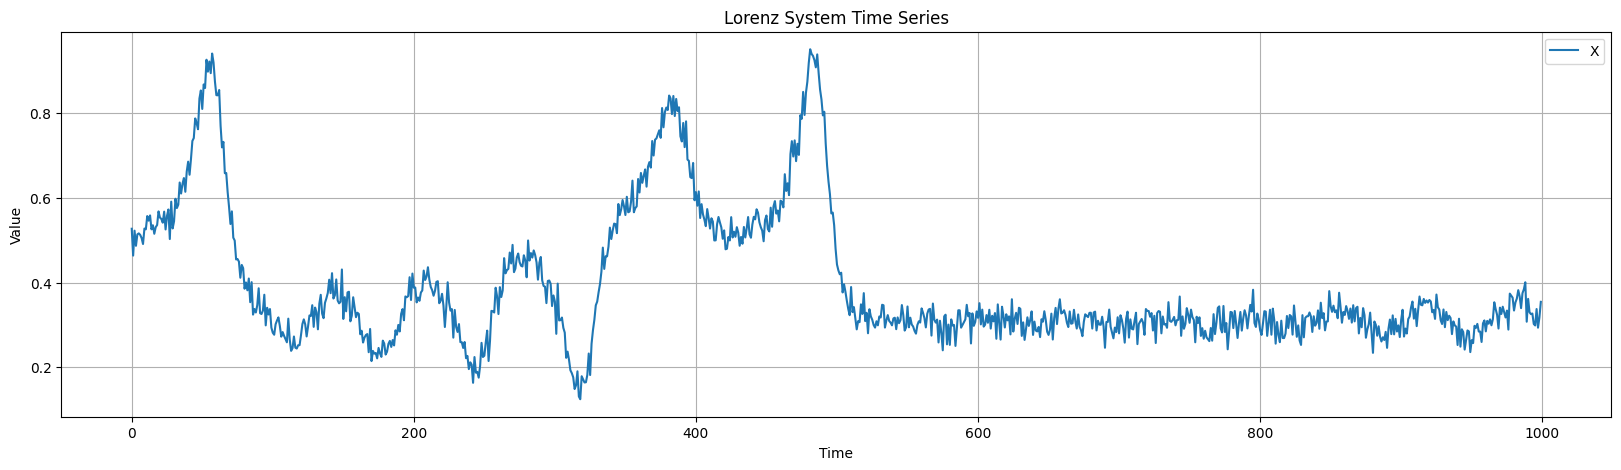

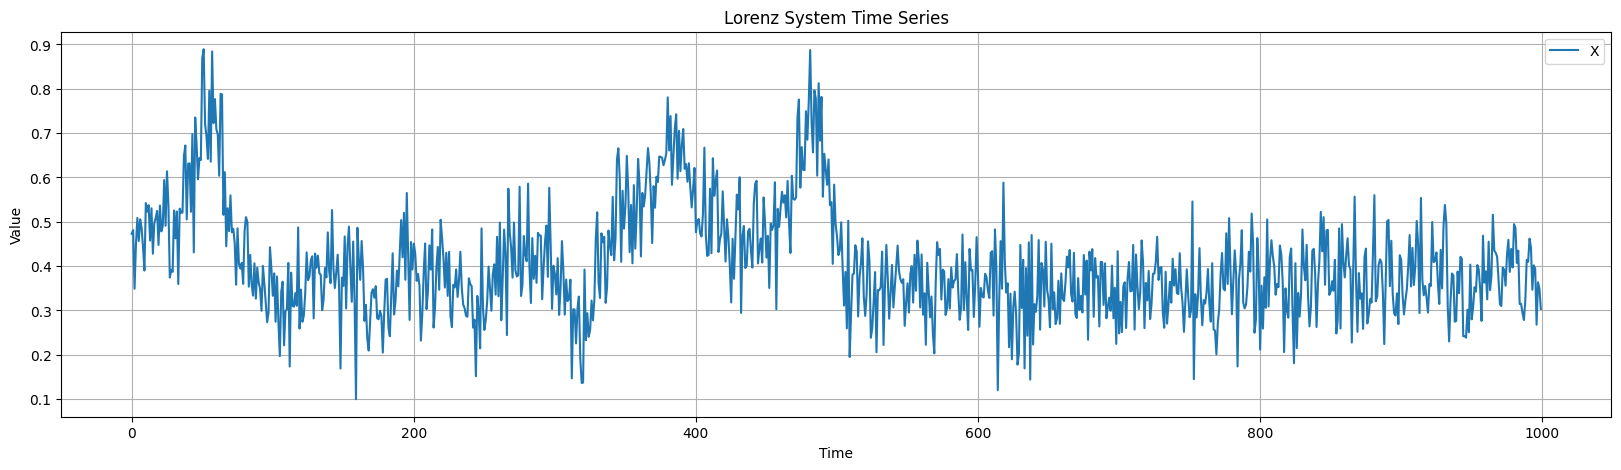

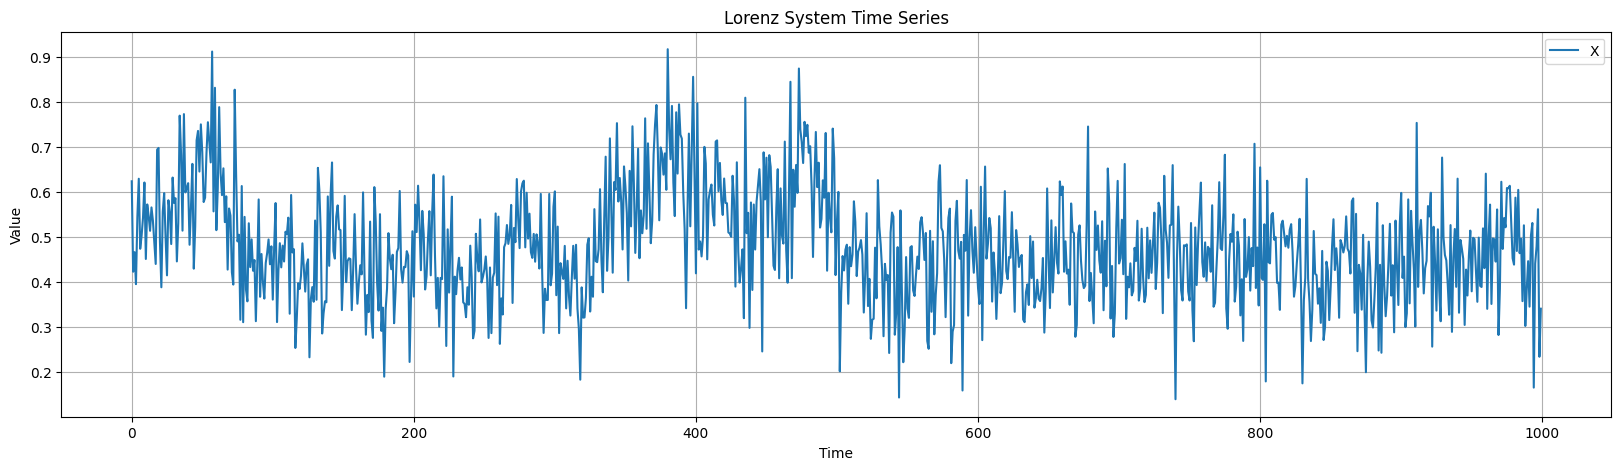

In [ ]:
timeSeries = []
std = [1, 5, 10]
mu = 0.1

for value in std:
  noise = np.random.normal(mu, value, size = x.shape)
  timeserie = x + noise

  # Normalization
  timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))
  timeSeries.append(timeserieNormalized)

  plt.figure(figsize=(20, 5))
  plt.plot(timeserieNormalized[0:1000], label='X')
  plt.title('Lorenz System Time Series')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
  plt.show()


##**Parameter variation**

In [ ]:
valuesDict = {}
windows = np.arange(3,21,1)

for serie, value in zip(timeSeries, np.arange(0, len(timeSeries), 1)):

  data_Aux = {}

  print(" \n Time serie {value}".format(value=value+1))

  for window in windows:

    #print(" \n Time serie {value} with size window {window}".format(value=value+1, window=window))

    # Input
    X = np.zeros([len(serie)-window, window])
    for i in range(len(serie)-window):
      X[i,:] = serie[i:i+window].T
    # Output
    y = serie[window:]

    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

    #print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

    data_Aux[str(window)] = {'Train': [X_train, y_train], 'Valid': [X_valid, y_valid], 'Test': [X_test, y_test]}

  valuesDict["Serie {}".format(str(value+1))] = data_Aux



 
 Time serie 1
 
 Time serie 2
 
 Time serie 3


#**Forecasting**

In [ ]:
max_window = windows.shape[0]
max_window

18

## RFF Conv-1d

In [ ]:
output_dim = 100
epochs = 100
results = []

for serie in valuesDict.keys():

  print(" \n\t {serie} ".format(serie=serie))
  performanceAppraisal = {}
  matriz = np.zeros((20,max_window))

  for window in valuesDict[serie].keys():

    # Data ---------------------------------------------------------------------
    X_train, y_train = valuesDict[serie][window]["Train"][0], valuesDict[serie][window]["Train"][1]
    X_valid, y_valid = valuesDict[serie][window]["Valid"][0], valuesDict[serie][window]["Valid"][1]
    X_test, y_test   = valuesDict[serie][window]["Test"][0], valuesDict[serie][window]["Test"][1]

    print(" \n\t {serie} - {window}".format(serie=serie, window=window))

    for j in range(1,int(window)+1,1):

      #print(j)

      # Neural network ---------------------------------------------------------
      input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')

      tmp = Conv1dRFF(output_dim, kernel_size=j)(input)
      tmp = tf.keras.layers.Flatten()(tmp)
      tmp = tf.keras.layers.Dense(units=32, activation='relu',name='Dense_1')(tmp)
      tmp = tf.keras.layers.Dense(units=16, activation='relu',name='Dense_2')(tmp)
      output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

      model = tf.keras.Model(inputs=input, outputs=output)
      model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

      history = model.fit(X_train, y_train, epochs=epochs, batch_size=98304, validation_data=(X_valid, y_valid), verbose=0)

      # Inference --------------------------------------------------------------
      forecasting = model.predict(X_test)

      # Metric -----------------------------------------------------------------
      r2 = round(r2_score(y_test, np.squeeze(forecasting)), 3)

      matriz[int(j-1), int(window)-3] = r2

      #matriz[int(j-1), int(window)-3] = 1

  results.append(matriz)



 
	 Serie 1 
 
	 Serie 1 - 3
188/188 [==============================] - 1s 3ms/step
 
	 Serie 1 - 4
188/188 [==============================] - 1s 2ms/step
 
	 Serie 1 - 5
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 6
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 7
188/188 [==============================] - 1s 2ms/step
 
	 Serie 1 - 8
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 9
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 10
188/188 [==============================] - 1s 2ms/step
 
	 Serie 1 - 11
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 12
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 13
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 14
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 15
188/188 [==============================] - 0s 2ms/step
 
	 Serie 1 - 16
188/188 [==============================] 

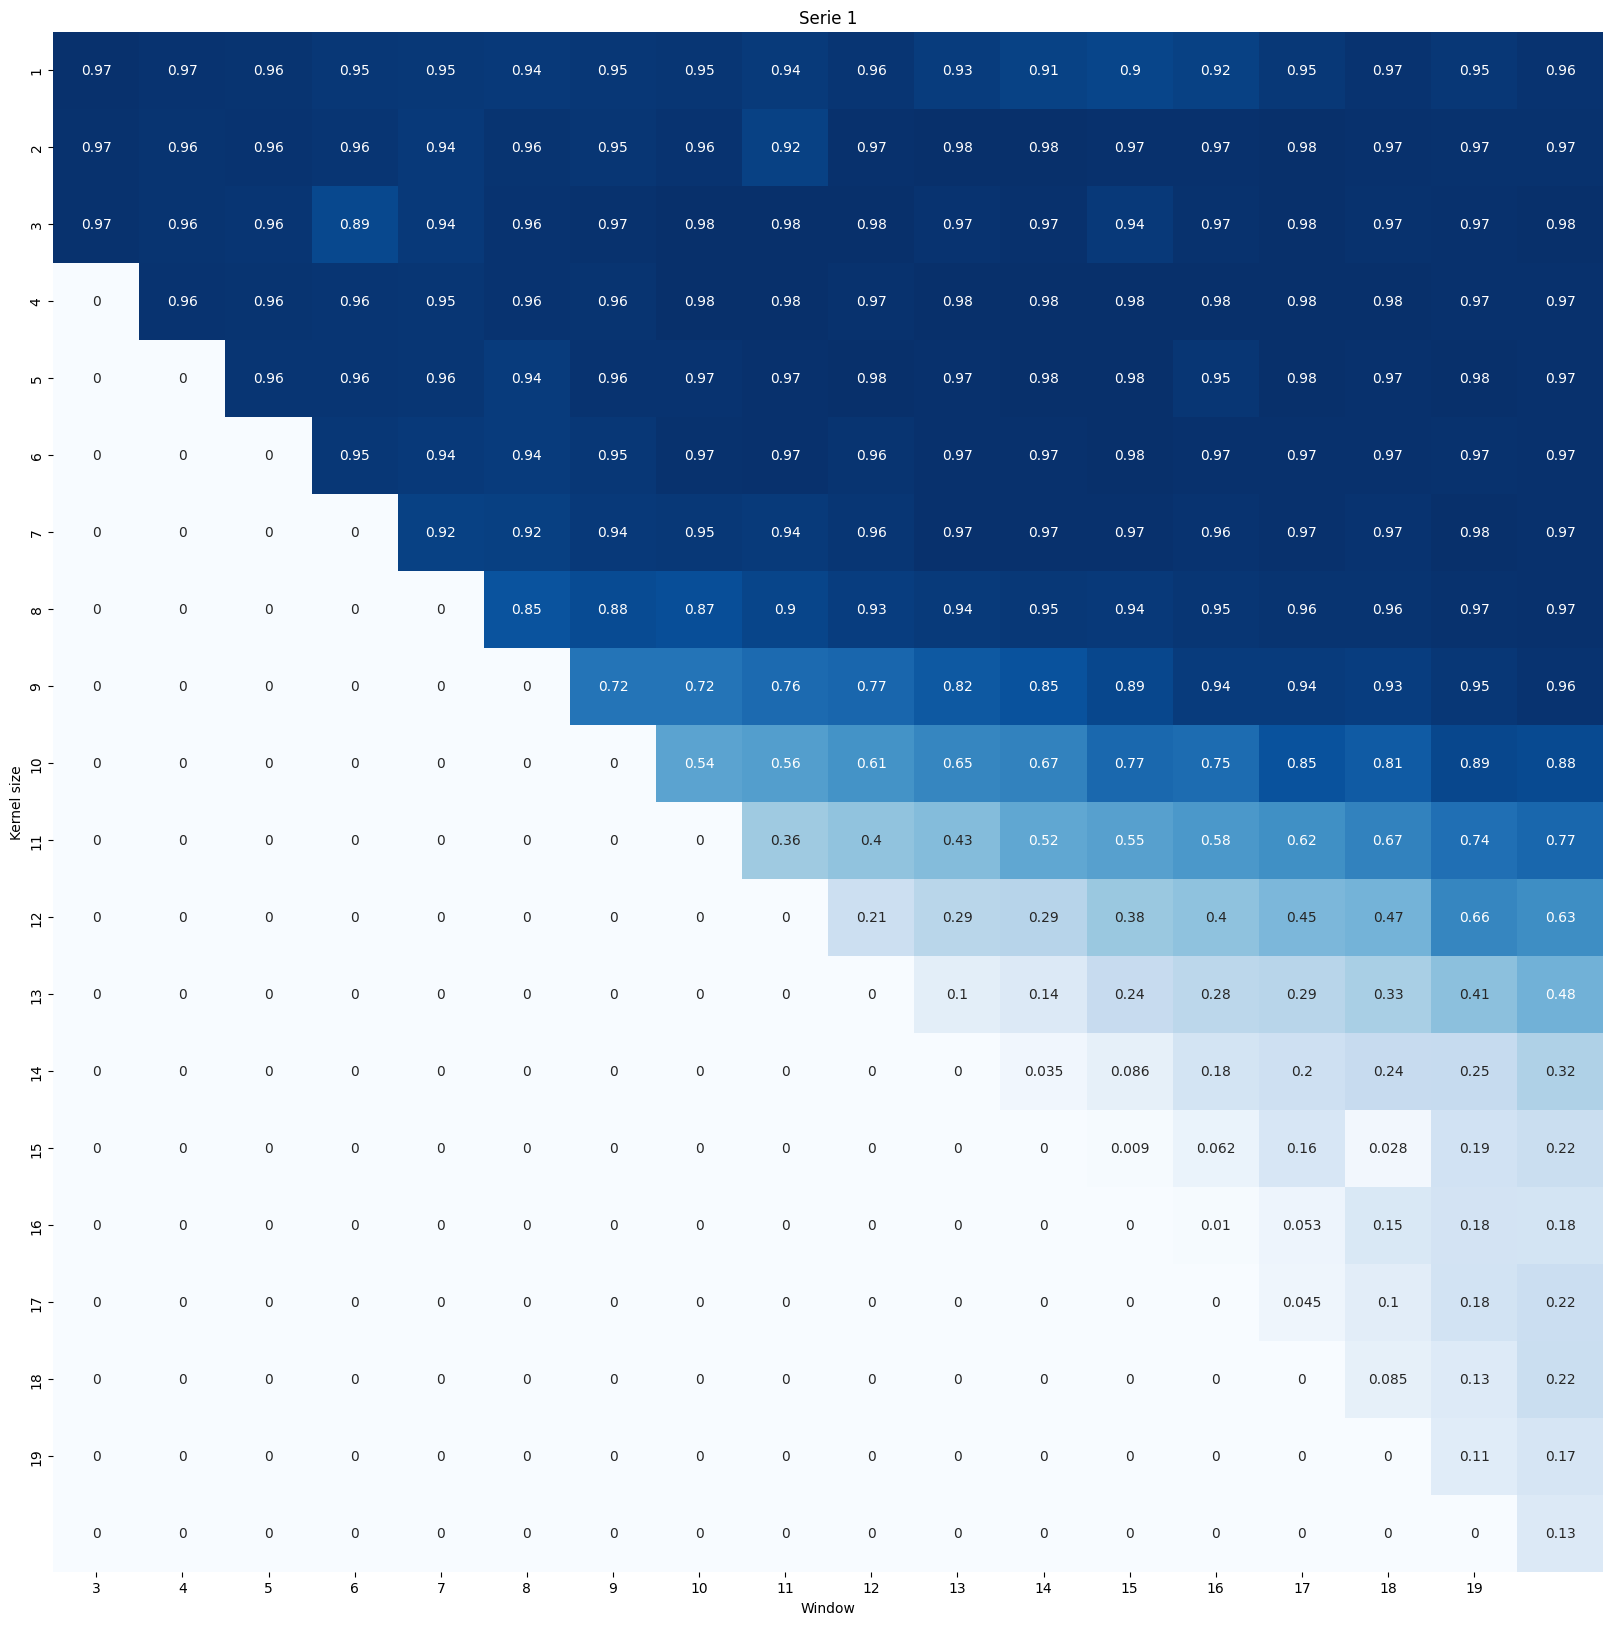

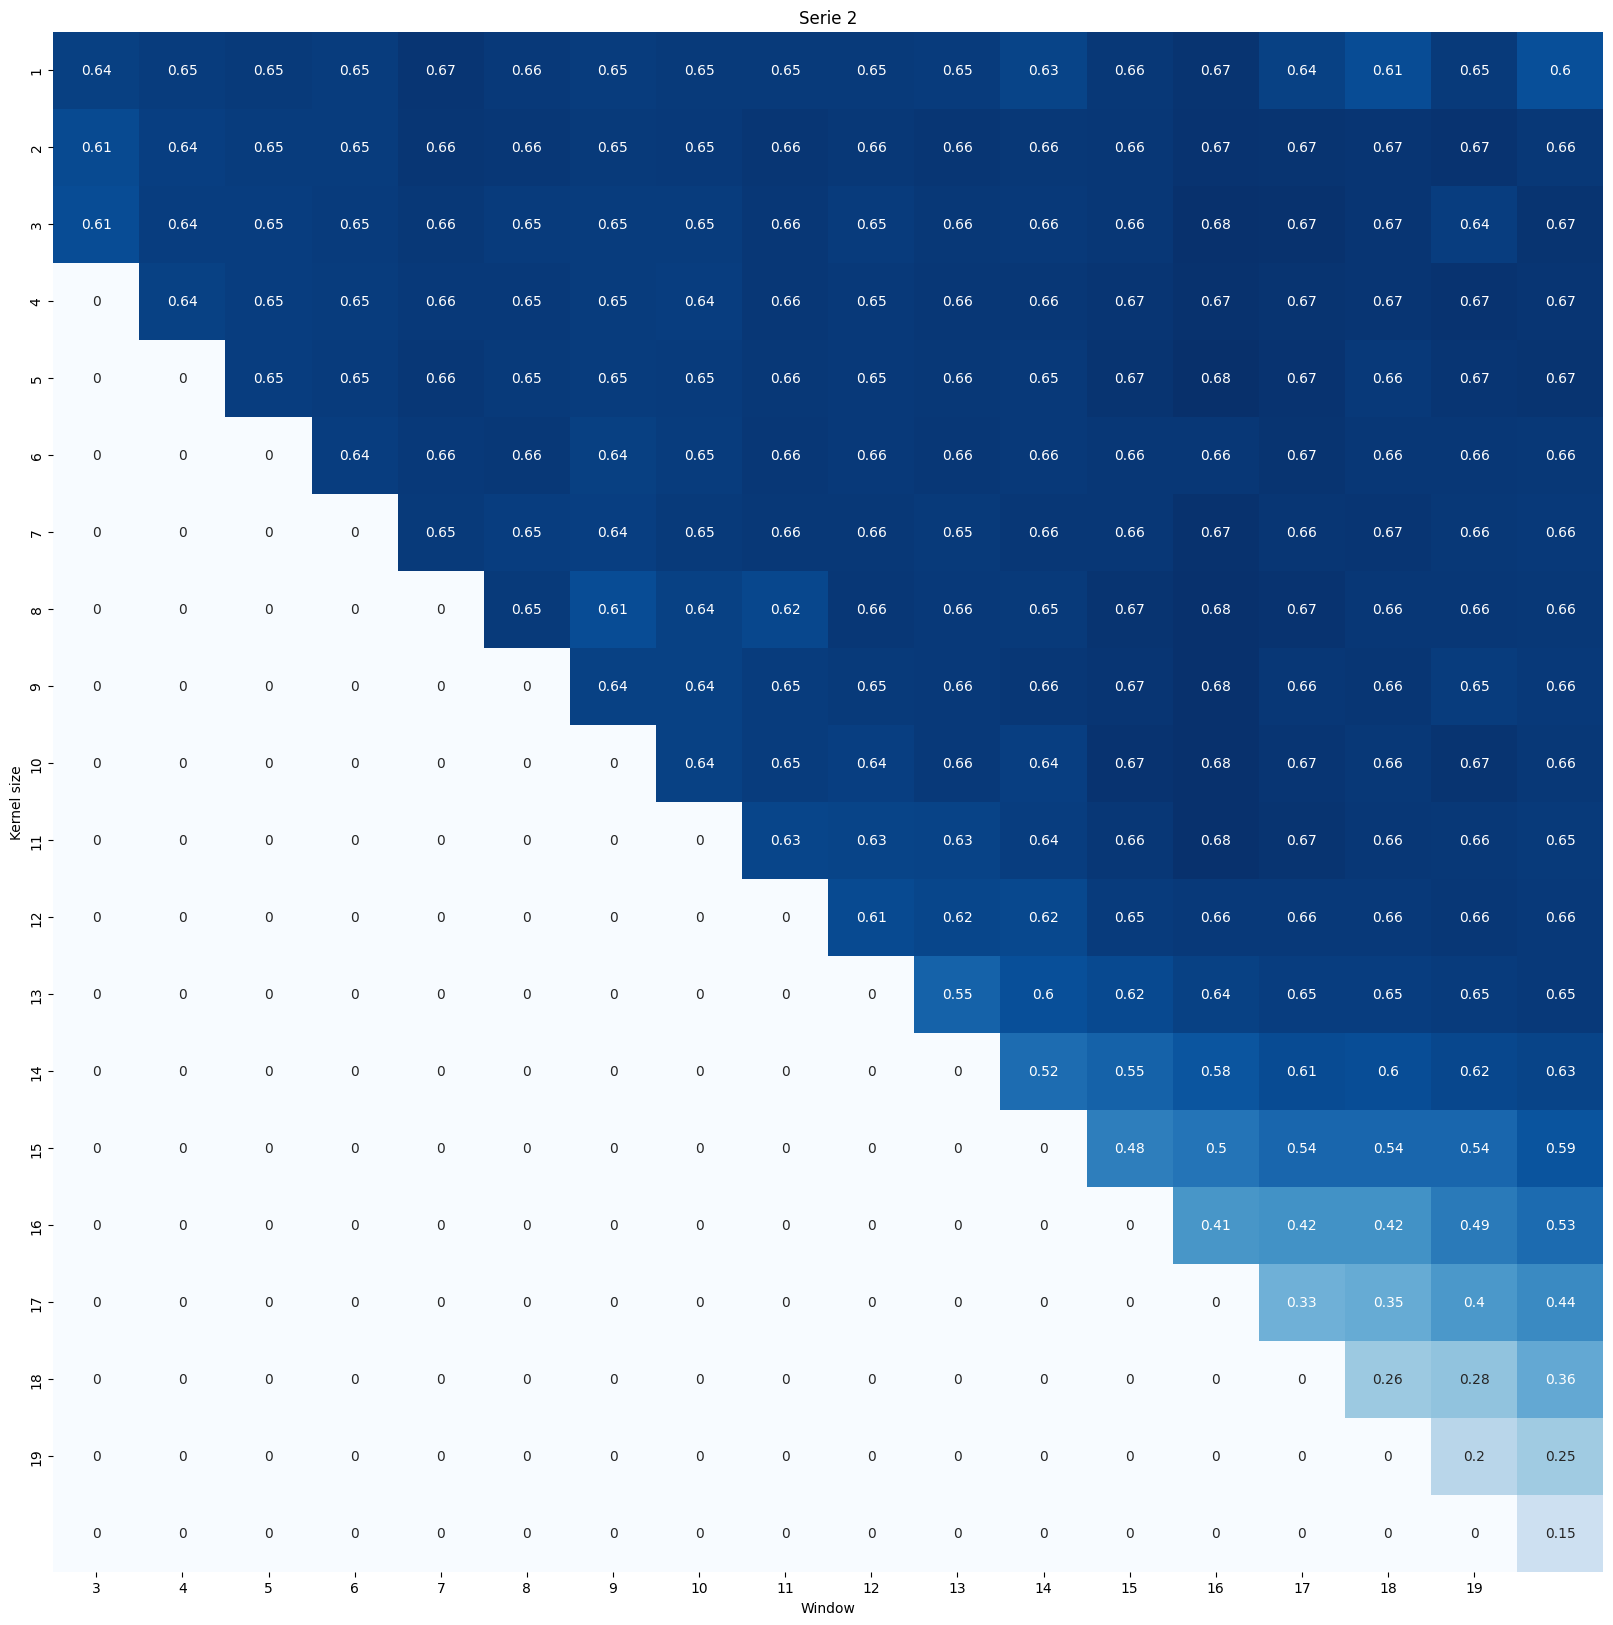

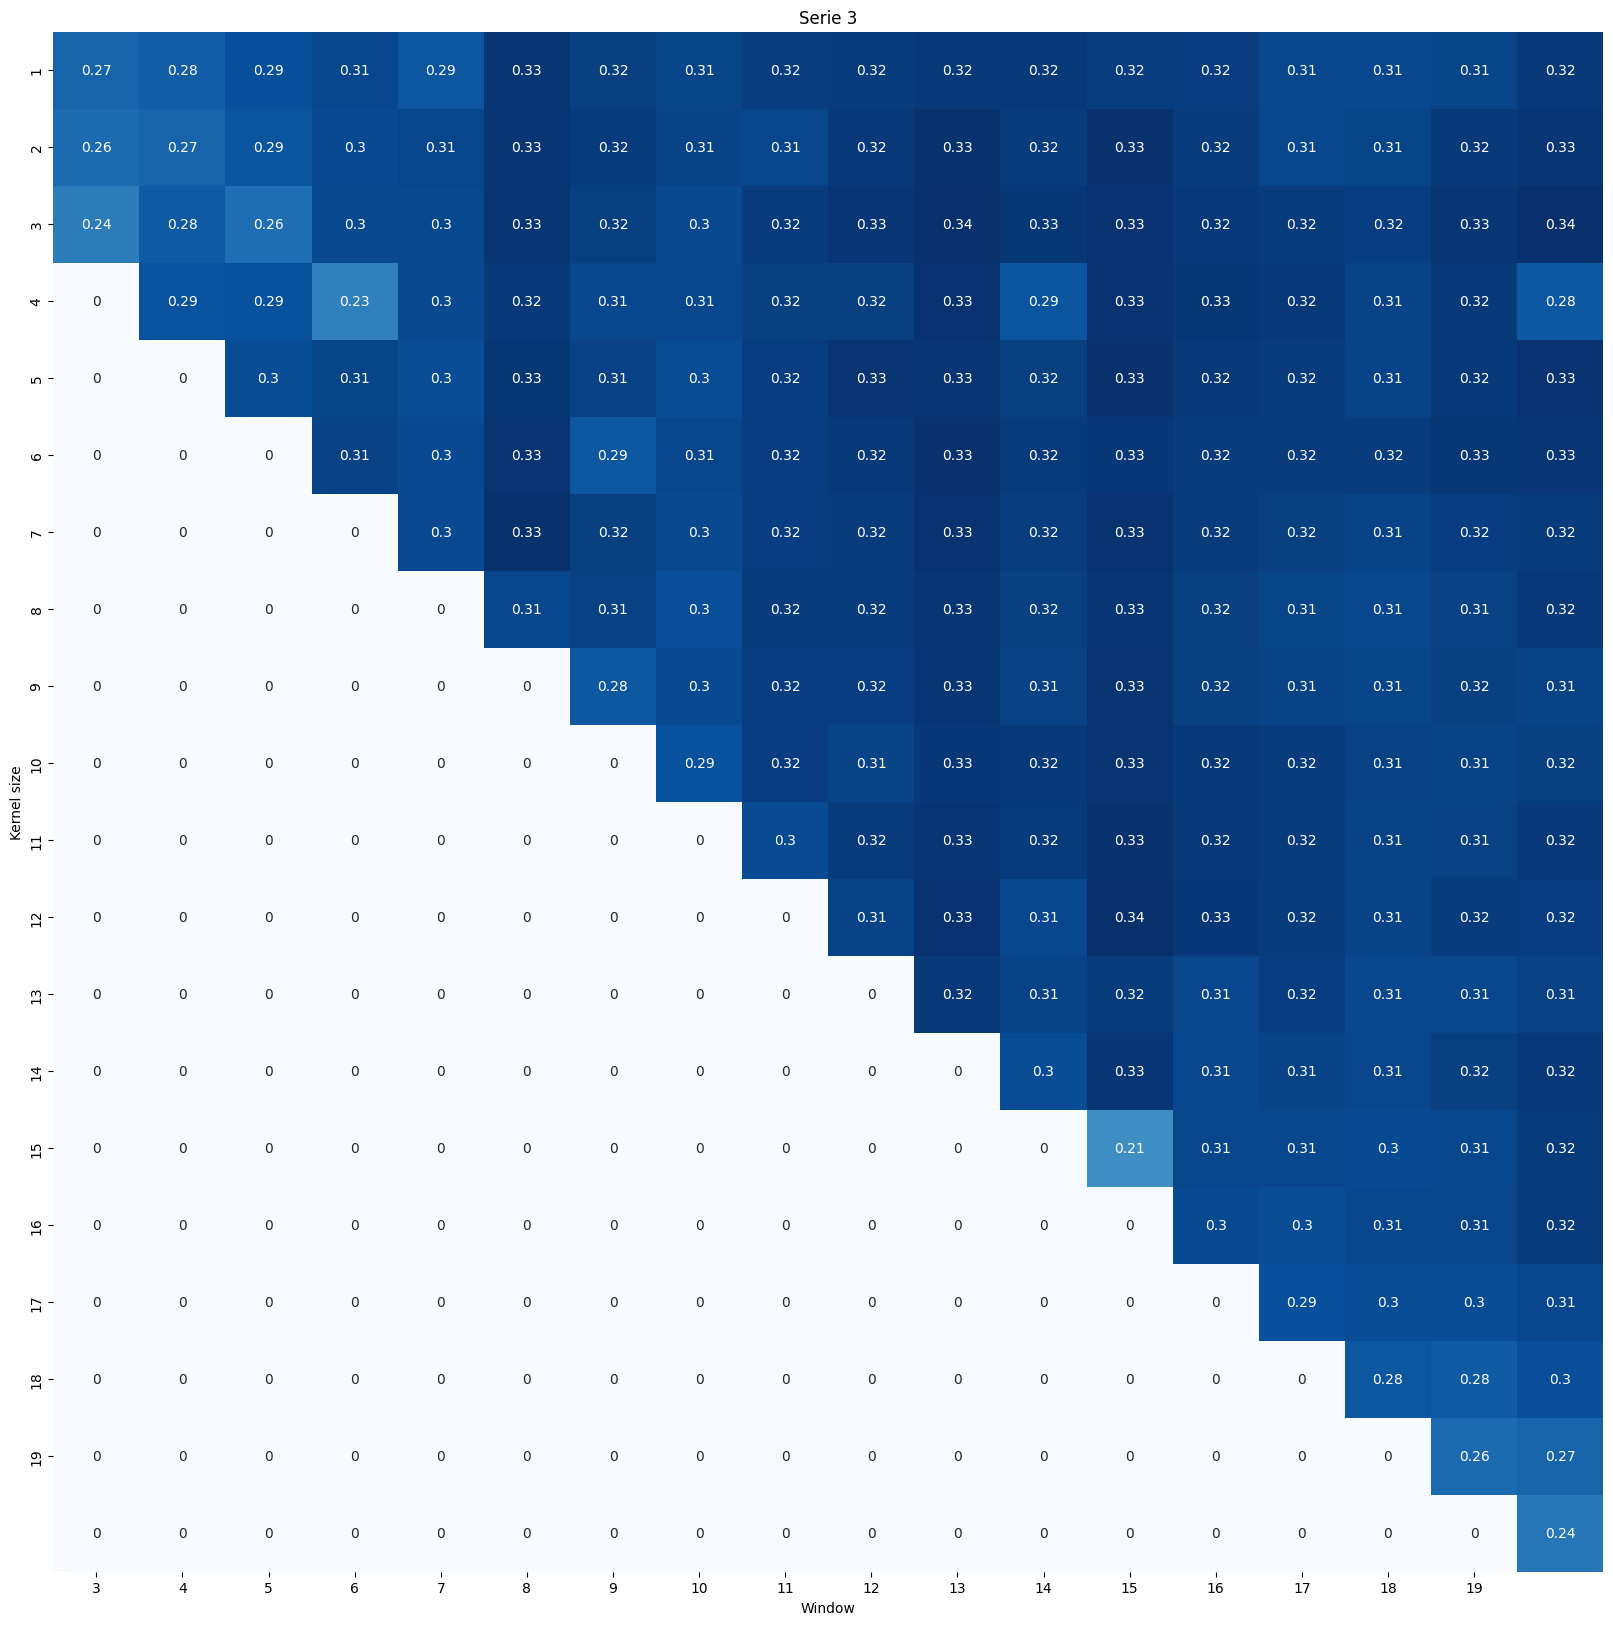

In [ ]:
for k in range(len(results)):

  plt.figure(figsize=(20,20))
  ax = sns.heatmap(data=results[k], annot=True, cbar=False, cmap="Blues",
                   yticklabels=range(1, 20, 1), xticklabels=range(3, 20, 1))
  ax.set(xlabel ="Window", ylabel = "Kernel size", title="Serie {}".format(k+1))

  plt.show()


In [ ]:
import pickle

picklefile = "results_proof2.pkl"
with open(picklefile, "wb") as pkl_wb_obj:
    pickle.dump(results, pkl_wb_obj)